#<strong>Project_notebook</strong>

---




# Introduction




> The aim of the project is to design an agent to play a docking game using reinforcement learning. Since the early 1950s, researchers have been using AI agents to play board games. With the development of reinforcement learning, the performance of AI in games has gradually improved. Reinforcement learning is a method for computers to learn optimal policies by interacting with the environment.  In the self-developed docking game, the agent will control the movement of the chaser towards the target, which appears on the right boundary of the screen, without hitting the boundary. The game world continuously changes, with new target positions generated each time the game starts or after successfully reaching a target. Based on our dynamic environment, deep Q learning is used for action selection for the agent.<br>

> The reason for choosing to train the agent to play games is that the game can provide a relatively simple and easy-control environment. The game has clear training objectives, a score system, and a clear reward and punishment mechanism. These features can be used to test and verify the performance of AI algorithms and these algorithms can be iterated and optimized in the game.<br>


> There are also some problems in the process of exploration. First of all, since the game environment is in a dynamic change, this will cause the agent to have different convergence functions for targets with different coordinates.<br>On the other hand, the setting of the reward also needs to be considered.A small reward may cause the agent to learn slowly, while the large reward may make the learning process unstable.<br>In addition, In order to find the best combination of hyperparameters, various parameters of the agent also need to be adjusted repeatedly according to the training situation, so that the agent can obtain the best performance during the training process







#Reinforcement Learning Task

To visually demonstrate the effects of reinforcement learning, a game environment is developed from scratch. The following code demonstrates the process of establishing the gaming environment<br>  

##**Environment settings**

**Initially, import the required lirbaries into the project.
Intinialize and import the environment, this project uses the pygame model to assist the environment intinialization.**

In [ ]:
import numpy as np
import pygame
import random
from enum import Enum
from collections import namedtuple

pygame.init()
font = pygame.font.Font(None, 24)

**The dockbox in the game has four directions.The right direction is 0, left direction is 1, the up direction is 2 and the down direction is 3.**

In [ ]:

class Direction(Enum):
    RIGHT = 0
    LEFT = 1
    UP = 2
    DOWN = 3

**Define the initial colour and point for the pygame. The size of the block is 20, the margin between the boundary and central point is 20.**

In [ ]:
Point = namedtuple('Point', 'x, y')

# rgb colors
WHITE = (255, 255, 255)
RED = (200, 0, 0)
BLUE1 = (0, 0, 255)
BLUE2 = (0, 100, 255)
BLACK = (0, 0, 0)

BLOCK_SIZE = 20
MARGIN = 20
SPEED = 40
TRAPEZOID_HEIGHT = BLOCK_SIZE // 2


**Use the previous colors and position variables to create the pygame.**

In [ ]:
def draw_shape(surface, color):
  pygame.draw.rect(surface, color, pygame.Rect(0, 0, BLOCK_SIZE, BLOCK_SIZE))
  pygame.draw.polygon(surface, color,[(0, BLOCK_SIZE), (BLOCK_SIZE / 2, BLOCK_SIZE + TRAPEZOID_HEIGHT), (BLOCK_SIZE, BLOCK_SIZE)])

**Initialise the parameters of the docking game. Here,the width of the playground is 640, and the height of playground is 480. The set angle of the traget and chaser block are both 90 degree.**

In [ ]:
class DockingGame:
    def __init__(self, Y_pos=-1, w=640, h=480):
        # Set the screen size
        self.Y_pos = Y_pos
        self.w = w
        self.h = h
        # Create the screen
        self.display = pygame.display.set_mode((self.w, self.h))
        # Set the caption of the screen
        pygame.display.set_caption('DockingGame')
        # Create the global clock
        self.clock = pygame.time.Clock()
        # Set the direction of the chaser
        self.direction = Direction.UP
        # Set the angle of the chaser
        self.chaser_angle = 90
        # Set the angle of the target
        self.target_angle = 90
        # Set the position of the chaser
        self.chaser = Point(40,
                            (self.h // 2 // BLOCK_SIZE) * BLOCK_SIZE)
        # Create the surface of the chaser
        self.chaser_surface = pygame.Surface((BLOCK_SIZE, BLOCK_SIZE + TRAPEZOID_HEIGHT), pygame.SRCALPHA)

        self.target = None
        # Create the surface of the target
        self.target_surface = pygame.Surface((BLOCK_SIZE, BLOCK_SIZE + TRAPEZOID_HEIGHT), pygame.SRCALPHA)
        # Create the state matrix
        self.states = np.zeros(6, dtype=int)
        # Set the game over flag
        self.is_game_over = False
        # Define the initial target
        draw_shape(self.chaser_surface, BLUE1)
        self.new_target()

**Reset the two docks back to the intitial state when the game is completed by the agent. After the reseting, the chaser always gets back to the start position.**

In [ ]:
    def reset(self):
      # reset the all the parameters to the initial state
      self.clock = pygame.time.Clock()
      self.direction = Direction.UP
      self.chaser_angle = 90
      self.target_angle = 90
      self.chaser = Point(40,(self.h // 2 // BLOCK_SIZE) * BLOCK_SIZE)
      self.chaser_surface = pygame.Surface((BLOCK_SIZE, BLOCK_SIZE + TRAPEZOID_HEIGHT), pygame.SRCALPHA)
      self.target = None
      self.target_surface = pygame.Surface((BLOCK_SIZE, BLOCK_SIZE + TRAPEZOID_HEIGHT), pygame.SRCALPHA)
      self.states = np.zeros(6, dtype=int)
      self.is_game_over = False
      self.new_target()
      draw_shape(self.chaser_surface, BLUE1)


**The target block starts from the right edge of the picture, each step is two times of the block size. For every new session, the target block will appear in a random position along the right edge.**

In [ ]:
    def new_target(self):
        x = 600
        # Define the y position of target
        step_size = BLOCK_SIZE * 2
        steps = (self.h - BLOCK_SIZE) // step_size
        random_step = random.randint(1, steps - 1) * step_size
        print(random_step)
        if self.Y_pos == -1:
            y = random_step
        else:
            y = self.Y_pos
        # Define the new position of the target
        self.target = Point(x, y)
        # Import the rotation function
        self.set_target_rotation()
        # Draw the target on the interface
        draw_shape(self.target_surface, RED)
        if self.target == self.chaser:
            self.new_target()



**The following functions define the movement and the terminate conditions of the docking game.The chaser moves with the four direction. The game will terminate if the chaser hit the target or the boundaries. The chaser will successfully hit the target if the distance between the them is less than 40.**

In [ ]:
    def ai_player_step(self, action):
        # Define the moving direction of the AI chaser
        if action.index(1) == 0:
            self.direction = Direction.UP
        if action.index(1) == 1:
            self.direction = Direction.DOWN
        if action.index(1) == 2:
            self.direction = Direction.RIGHT

        # Move the AI chaser
        self.move(self.direction)
        # Update the states
        self.update_states()

        # check if the AI chaser hits the boundary
        if self.is_collision():
            self.is_game_over = True
        # check if the AI chaser hits the target
        if abs(self.target.x - self.chaser.x) <= 40 and abs(
                self.target.y - self.chaser.y) <= 40:
            self.is_game_over = True
        # Render the interface
        self.render()

    def is_collision(self):
        # check if the AI chaser hits the boundary
        if self.chaser.x > self.w - BLOCK_SIZE or self.chaser.x < 0 or self.chaser.y > self.h - BLOCK_SIZE or self.chaser.y < 0:
            return True
        return False

    def is_collision_ver(self):
        # check if the AI chaser hits the vertical boundary
        if self.chaser.y > self.h - BLOCK_SIZE or self.chaser.y < 0:
            return True

        return False

**This part of the function check:**


1.  **Chaser block position with graph boundary**

  The function updata the chaser block movement by comparing with the current x,y value with the margin value.Then comparsion result could indicate whether the chaser is close to the top or bottom boundary.
2.  **Relative position of chaser and target**

  By compare self.chaser.y and self.target.y, the program know whether the chaser is located above or up the target.

In [ ]:
    def update_states(self):
      self.states[0] = (self.direction == Direction.UP)
      self.states[1] = (self.direction == Direction.DOWN)
      # up
      if self.chaser.y - MARGIN < 0 and self.direction == Direction.UP:
          self.states[2] = 1
      # down
      if self.chaser.y + MARGIN > self.h and self.direction == Direction.DOWN:  # down
          self.states[3] = 1
      self.states[4] = (self.chaser.y < self.target.y)  # relative target location
      self.states[5] = (self.chaser.y > self.target.y)

    def get_states(self):
      return self.states

**The render function updates the game display by drawing the chaser and target objects onto the screen at their respective positions and orientations. The rotation of the chaser and target surfaces is controlled by the self.chaser_angle and self.target_angle variables, respectively.**

In [ ]:
    def render(self):
      self.display.fill(BLACK)
      rotated_chaser_surface = pygame.transform.rotate(self.chaser_surface, self.chaser_angle)
      self.display.blit(rotated_chaser_surface, (self.chaser.x, self.chaser.y))
      rotated_target_surface = pygame.transform.rotate(self.target_surface, self.target_angle)
      self.display.blit(rotated_target_surface, (self.target.x, self.target.y))
      pygame.display.flip()

**The following functions are responsible for determining the correct rotation angles for the chaser and target objects, which are used later in the render function to properly rotate and display the objects on the game screen.**

**'get_chaser_rotation(self)' function** returns the rotation angle for the chaser object based on its current direction. If the chaser is moving to the right, the rotation angle is 90 degrees; if it's moving to the left, the angle is -90 degrees; if it's moving upward, the angle is 180 degrees; and if it's moving downward, the angle is 0 degrees.

**'get_target_rotation' function** calculates the rotation angle for the target object. It considers the current position of the target and checks if it's close to any of the four edges of the game screen (within a certain margin). If it is close to the left or right edge, the rotation angle is set to -90 or 90 degrees, respectively. If it's close to the top edge, the angle is 0 degrees, and if it's close to the bottom edge, the angle is 180 degrees. If the target is not close to any edge, a random rotation angle from the set [0, 90, 180, -90] is chosen.

**Important note**  In our actual training, we didn't really fire up the ship's attitude control engines to operate their docking angles. This is because adding a state to the state space would make training much more expensive. This is not something that can be improved using efficient techniques. We don't have high performance servers to deploy parallel computing for learning, so we dropped this feature in the demonstration session



In [ ]:
    def get_chaser_rotation(self):
        if self.direction == Direction.RIGHT:
            return 90
        elif self.direction == Direction.LEFT:
            return -90
        elif self.direction == Direction.UP:
            return 180
        elif self.direction == Direction.DOWN:
            return 0

    def get_target_rotation(self):
        margin = BLOCK_SIZE * 5
        if self.target.x <= margin:
            return 90
        elif self.target.x >= self.w - margin:
            return -90
        elif self.target.y <= margin:
            return 0
        elif self.target.y >= self.h - margin:
            return 180
        else:
            directions = [0, 90, 180, -90]
            return random.choice(directions)

    def set_target_rotation(self):
        self.target_angle = self.get_target_rotation()

    def set_chaser_rotation(self):
        self.chaser_angle = self.get_chaser_rotation()

**The 'move(self, direction)' function** is responsible for updating the position of the chaser object based on the given direction. It takes the direction as an input argument and modifies the x and y coordinates of the chaser accordingly to move it in the specified direction. By calling this function with different directions, the chaser can be moved in different directions on the game screen.

In [ ]:
    def move(self, direction):
        x = self.chaser.x
        y = self.chaser.y
        if direction == Direction.DOWN:
            y += BLOCK_SIZE
        elif direction == Direction.UP:
            y -= BLOCK_SIZE

        x += BLOCK_SIZE // 2

        self.chaser = Point(x, y)


**The principle of the reward is based on three rules:**


1. **Vertical Distance Penalty**

 The reward is calculated as -0.001 times the absolute difference between the y coordinate of the chaser (self.chaser.y) and the y coordinate of the target (self.target.y). This penalty encourages the chaser to minimize the vertical distance to the target and move closer vertically.
2. **Boundary Collision Penalty**

  If the chaser collides with the top or bottom boundary of the game screen, as determined by the self.is_collision_ver() function, a penalty of -0.1 is assigned to the reward. This negative reward encourages the chaser to avoid colliding with the top or bottom boundaries and stay within the playable area.
3. **Proximity to Target Reward**

 If the horizontal and vertical distances between the chaser and the target are both less than or equal to 40 (i.e., abs(self.target.x - self.chaser.x) <= 40 and abs(self.target.y - self.chaser.y) <= 40), it means the chaser is very close to the target. In this case, the reward is set to 1000. This positive reward encourages the chaser to get as close as possible to the target, indicating a successful docking.






In [ ]:
    def compute_reward(self):
        reward = -0.001*(abs(self.chaser.y-self.target.y))
        if abs(self.target.x - self.chaser.x) <= 40 and abs(self.target.y - self.chaser.y) <= 40:
            reward = 1000

            return reward
        if self.is_collision_ver():

            reward = -0.1

        return reward

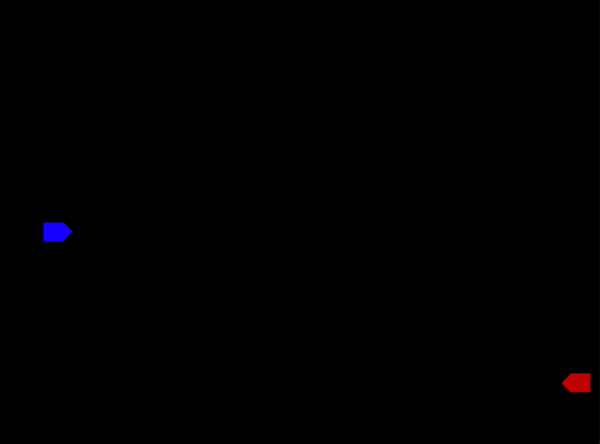

The gif above demonstrates the simulation of the docking game after training. The chaser will move toward the target. Whnen it hit the target successfully, the inferface will be reset. Then the target will appear at a random position along the right edge. The game will keep running until terminated manually.

##**Method option 1 (Simple linaer netwrok Agent model)**

The model 1 is a two layers linear network DQN model. In this model, the network is contributed by two 128 size linear network. The environment is based on the previous pygame modules, and the agent follow the reward and penatly rules which includes in the previous environment code. After the network return the Q values, the agent make the decision in next step with the reward result.

###Model 1 part 1: DQN Class Definition

This class represents the neural network architecture for the DQN. It has three fully connected layers: two hidden layers with 128 units each and an output layer with the number of units equal to the number of possible actions.

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt

import numpy as np
import torch.nn.functional as F
env = DockingGame()


class DQN(nn.Module):
    def __init__(self, obs_space, action_space):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(obs_space, 128)
        self.fc2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, action_space)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        action = self.out(x)
        return action

###Model 1 part 2: Training Function

The 'train_agent()' function is defined to carry out the training process.

In [ ]:
def train_agent():
    # Create the game environment
    game = DockingGame()

###Model 1 part 3: Hyperparameters and Optimizer

Hyperparameters like obs_space (size of the observation space), action_space (size of the action space), learning_rate, gamma (discount factor), epsilon (exploration factor), epsilon_min (minimum exploration factor), epsilon_decay (exploration decay rate), and n_games (number of episodes) are defined.An Adam optimizer is defined to update the model's parameters.

In [ ]:
    # Define the hyperparameters
    obs_space = 6  # The state space size (number of features)
    action_space = 3  # The action space size (number of possible actions)
    learning_rate = 0.001
    gamma = 0.9
    epsilon = 1.0
    epsilon_min = 0.01
    epsilon_decay = 0.999
    n_games = 1000  # Number of episodes

    # Create the DQN model and optimizer
    model = DQN(obs_space, action_space)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Variables to store learning curve data
    rewards_list = []
    average_rewards = [0]
    success_rate = []
    successful_episodes = 0

###Model 1 part 4：Training Loop

The script enters the training loop, where it iterates over a specified number of episodes (n_games). For each episode, it performs the following steps:

Obtains the initial state from the game environment.

1.   Executes actions in the environment while the episode is not done.
2.   Implements epsilon-greedy exploration strategy, where the agent chooses random actions with a probability of epsilon and otherwise selects the action with the highest predicted Q-value from the DQN.
3. Calculates the reward for the action, the next state, and whether the episode is done.
4.Computes the target Q-value using the Bellman equation.
5.Computes the predicted Q-value using the DQN for the current state and action.
6.Calculates the loss using mean squared error between predicted and target
7.Updates the current state for the next iteration.
Decays the exploration factor epsilon for the exploration-exploitation trade-off.

In [ ]:
    # Training loop
    for episode in range(n_games):
        state = torch.tensor(game.get_states(), dtype=torch.float).unsqueeze(0)
        done = False
        total_reward = 0

        while not done:
            # Epsilon-greedy exploration
            if np.random.rand() < epsilon:
                action = np.random.choice(action_space)
            else:
                with torch.no_grad():
                    action_values = model(state)
                    action = torch.argmax(action_values, dim=1).item()

            # Perform the action in the environment
            game.ai_player_step([int(i == action) for i in range(action_space)])

            # Get the next state and reward from the environment
            next_state = torch.tensor(game.get_states(), dtype=torch.float).unsqueeze(0)
            reward = game.compute_reward()
            total_reward += reward

            # Check if the game is over
            done = game.is_game_over

            # Compute the target Q-value
            if not done:
                with torch.no_grad():
                    next_action_values = model(next_state)
                    target = reward + gamma * torch.max(next_action_values)
            else:
                target = torch.tensor(reward, dtype=torch.float)

            # Compute the predicted Q-value
            current_action_values = model(state)
            predicted = current_action_values[0][action]

            # Compute the loss and perform gradient descent
            loss = F.mse_loss(predicted, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update the state for the next iteration
            state = next_state

        # Decay epsilon for exploration-exploitation tradeoff
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay
# Call the training function to start training the agent and visualize the learning curve and success rate
train_agent()

###Model 1 part 5: Model 1 results

This model cannot deal with the complex environment. Even though the project has trained 1000 epoch, the model still shows almost zero successful rate in the relay. In the learning curve, the curve keeps staying under positive 1, with zero successful rate.  This curve result shows the agent always leads the blue block to the penalty condition, such as hitting the boundary of the game environment or fail to reach the area of red block, Thus, this linear neutral network model is underfit for this project


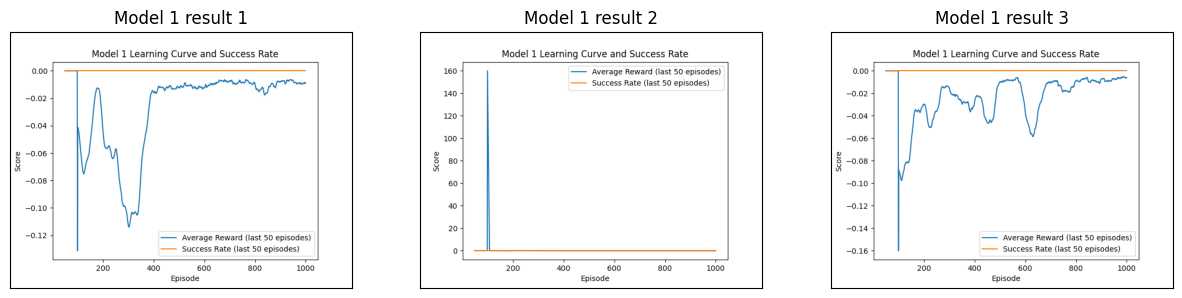

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('p1_1.png')
img2 = mpimg.imread('p1_2.png')
img3 = mpimg.imread('p1_3.png')

fig, axs = plt.subplots(1, 3, figsize=(15,5))  # 1 row, 3 images

axs[0].imshow(img)
axs[0].set_title('Model 1 result 1')
axs[1].imshow(img2)
axs[1].set_title('Model 1 result 2')
axs[2].imshow(img3)
axs[2].set_title('Model 1 result 3')

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

##**Method option 2 (Long-term memory DQN network Agent model)**

###Model 2 part 1: Linear networok

A simple feedforward neural network using PyTorch. This network architecture consists of two linear (fully connected) layers, where the input is passed through a ReLU activation function after the first linear layer. The network is designed to be used for some sort of reinforcement learning task.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os

class Linear_QNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

    def save(self, file_name='model.pth'):
        model_folder_path = './model'
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)

        file_name = os.path.join(model_folder_path, file_name)
        torch.save(self.state_dict(), file_name)

###Model 2 part 2: Improved DQN in Q-learning algorithm

 This part performs a single training step for the Q-learning algorithm. It takes the current state, action taken, received reward, next state, and a boolean indicating whether the episode is done. The method computes the Q-values using the Bellman equation and updates the neural network's weights based on the loss.

In [ ]:
class QTrainer:
    def __init__(self, model, lr, gamma):
        self.lr = lr
        self.gamma = gamma
        self.model = model
        self.optimizer = optim.Adam(model.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()

    def train_step(self, state, action, reward, next_state, done):
        state = torch.tensor(state, dtype=torch.float)
        next_state = torch.tensor(next_state, dtype=torch.float)
        action = torch.tensor(action, dtype=torch.long)
        reward = torch.tensor(reward, dtype=torch.float)
        # (n, x)

        if len(state.shape) == 1:
            # (1, x)
            state = torch.unsqueeze(state, 0)
            next_state = torch.unsqueeze(next_state, 0)
            action = torch.unsqueeze(action, 0)
            reward = torch.unsqueeze(reward, 0)
            done = (done,)

        # 1: predicted Q values with current state
        pred = self.model(state)

        target = pred.clone()
        for idx in range(len(done)):
            Q_new = reward[idx]
            if not done[idx]:
                Q_new = reward[idx] + self.gamma * torch.max(self.model(next_state[idx]))

            target[idx][torch.argmax(action[idx]).item()] = Q_new

        # 2: Q_new = r + y * max(next_predicted Q value) -> only do this if not done
        # pred.clone()
        # preds[argmax(action)] = Q_new
        self.optimizer.zero_grad()
        loss = self.criterion(target, pred)
        loss.backward()

        self.optimizer.step()


###Model 2 part 3: DQN Agent construction

This class represents an agent that uses Q-learning and a neural network to learn how to take actions in an environment to maximize cumulative rewards. The provided the model 2 agent's behavior, training procedures, and action selection strategies.Compared with model 1, the model 2 using the 256 size linear network with the same number of layers.

In [ ]:
MAX_MEMORY = 100_00000
BATCH_SIZE = 1000
LR = 0.001


class Agent:
    def __init__(self):
        self.n_games = 0
        self.epsilon = 0  # randomness
        self.gamma = 0.9  # discount rate
        self.memory = deque(maxlen=MAX_MEMORY)  # popleft()
        self.model = Linear_QNet(6, 256, 3)
        self.trainer = QTrainer(self.model, lr=LR, gamma=self.gamma)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))  # popleft if MAX_MEMORY is reached

    def train_long_memory(self):
        if len(self.memory) > BATCH_SIZE:
            mini_sample = random.sample(self.memory, BATCH_SIZE)  # list of tuples
        else:
            mini_sample = self.memory
        states, actions, rewards, next_states, dones = zip(*mini_sample)
        self.trainer.train_step(states, actions, rewards, next_states, dones)

    def train_short_memory(self, state, action, reward, next_state, done):
        self.trainer.train_step(state, action, reward, next_state, done)

    def get_action(self, state):
        # random moves: tradeoff exploration / exploitation
        self.epsilon = 10000 - self.n_games
        final_move = [0, 0, 0]
        if random.randint(0, 200) < self.epsilon:
            move = random.randint(0, 2)
            final_move[move] = 1
        else:
            state0 = torch.tensor(state, dtype=torch.float)
            prediction = self.model(state0)
            move = torch.argmax(prediction).item()
            final_move[move] = 1

        return final_move


###Model 2 part 4: Agent training in long-term memory DQN network

The loop runs for a specified number of episodes (in this case, 1000 episodes) and within each episode, the agent interacts with the environment, collects experiences, and updates its Q-network based on these experiences.
During the loop, the following operation is done:
1.   Reset the environment using 'env.reset()'.
2.   Set done to False to indicate the episode is not finished yet.
3. Initialize reward_total to keep track of the cumulative reward obtained in this episode.
4. Increment the agent's n_games counter.
5. Enter a loop where the agent interacts with the environment until the episode is done.
6. After the episode loop, the code train the agent's long-term memory using 'agent.train_long_memory()'.

In [ ]:
agent = Agent()
env = DockingGame()
plot_scores = []
plot_mean_scores = []
reward_list = []
success_rate_list = []
reward_total = 0
success_total = 0

for i in range(1000):
    env.reset()
    done = False
    reward_total = 0
    agent.n_games += 1
    while not done:
        pygame.event.get()
        state_old = env.get_states()
        action = agent.get_action(state_old)
        env.ai_player_step(action)
        reward = env.compute_reward()
        done = env.is_game_over
        state_new = env.get_states()
        agent.train_short_memory(state_old, action, reward, state_new, done)
        agent.remember(state_old, action, reward, state_new, done)
        env.clock.tick(10000)
        reward_total += reward

    agent.train_long_memory()
    # save the total reward and success rate
    reward_list.append(reward_total)

###Model 2 part 5: Model 2 results

The result shows a good performance in the docking game. In epoch 50, the model does not have sufficient training. The model shows underfitting during this training process. As the training epoch increase, the total success rate increase. In epoch 500, the success rate becomes stable and remains at 85%. When the number of epochs reaches 2000, the curve becomes stable with a good success rate in pygame.



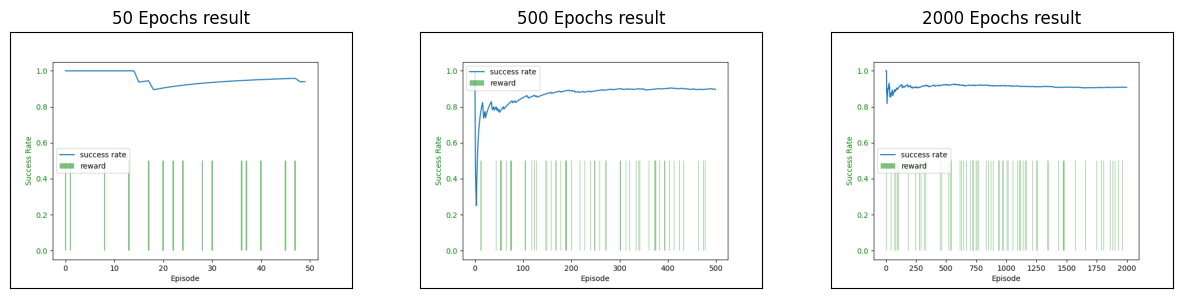

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('p6.png')
img2 = mpimg.imread('p8.png')
img3 = mpimg.imread('p10.png')

fig, axs = plt.subplots(1, 3, figsize=(15,5))  # 1 row, 3 images

axs[0].imshow(img)
axs[0].set_title('50 Epochs result')
axs[1].imshow(img2)
axs[1].set_title('500 Epochs result')
axs[2].imshow(img3)
axs[2].set_title('2000 Epochs result')

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

By comparing the success rate between model 1 and model 2, the model 2 performs better in the Pygame environment. The following figures show the comparison between model 1 and model 2 in the 50, 500, and 2000 epochs, respectively. Model 1 indicates an almost zero success rate when model 2 becomes more stable during the increasing number of epochs.

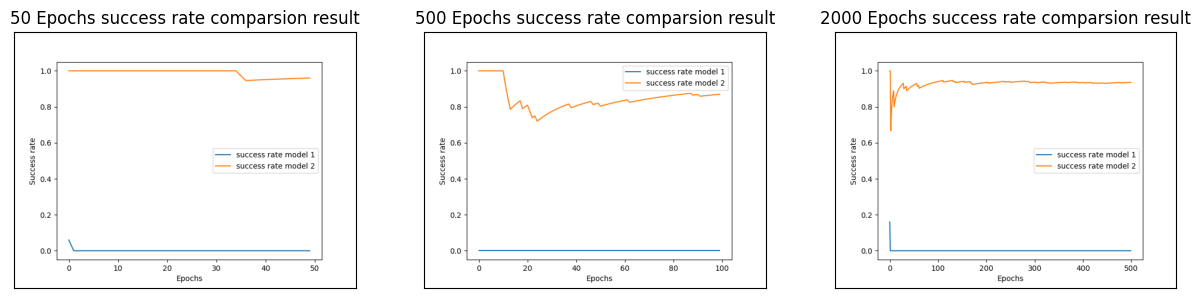

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('p2_2.png')
img2 = mpimg.imread('p2_1.png')
img3 = mpimg.imread('p2_3.png')

fig, axs = plt.subplots(1, 3, figsize=(15,5))  # 1 row, 3 images

axs[0].imshow(img)
axs[0].set_title('50 Epochs success rate comparsion result')
axs[1].imshow(img2)
axs[1].set_title('500 Epochs success rate comparsion result')
axs[2].imshow(img3)
axs[2].set_title('2000 Epochs success rate comparsion result')

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

##**Method option 3 (DQN Agent Model with dynamic greedy parameters)**



###Model 3 part 1:Training environment
- **Deque**:The memorydeque provides O(1) time complexity for insertion and deletion operations when the reinforcement agent needs to update it frequently. This means that insert and delete operations will take the same amount of time no matter how large the queue is. Saves training computations。
random: is used to randomly generate the location of the target object.
- **pygame**:the customed game environment is based on the pygame library
matplotlib:Record and visualize training as well as resultant data
- **os**：For saving and reading models
- **torch.nn**： Create the layers of the neural network in the DQN and define the loss function
- **torch.optim**:Initialization optimizer for model parameter updates
- **torch.nn.functional**:Functions used to construct neural networks, activation function, loss function. In this project it is mainly used to import the activation function.

In [ ]:
from collections import deque
import random

import matplotlib.pyplot as plt
import pygame
from matplotlib.pyplot import plot

from newgame import DockingGame
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os

###Model 3 part 2:Feed-forward neural network structure
- This class represents a simple feed-forward neural network, which is often used to implement the neural network version of Q-Learning
-The content in the init method is the main components of the neural network in DQN with two linear layers linear1,and linear2. and using super(). _init_(), to initialize the parent class.
The forward method defines the forward propagation of the network so that the data passes sequentially through linear layer 1, the ReLu activation function, and finally through linear layer 2.
- the last function is used for the saving of the model.
- The input to this network is a state and the output is a Q-value for each possible action, the Q-value representing the expected payoff for taking an action in a given state.

In [ ]:

class Linear_QNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

    def save(self, Y):
        model_folder_path = './model'
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)

        file_name = os.path.join(model_folder_path, 'Y_' + str(Y) + 'model.pth')
        torch.save(self.state_dict(), file_name)

###Model 3 part 3:QTrain class
The QTrainer class is a trainer to update the parameters of Linear_QNet for better Q estimation. It is also a concrete implementation of the Q learning algorithm.
This trainer updates the Q-values by means of the Bellman equation, which describes the relationship between the Q-value of the current state and action and the maximum Q-value of the next state.
##initialization
- In this class first it defines model we used, the learnign rate and discount factor.

- The model is used to predict the Q value for each action.
In addition he defines the trainer's learning rate and the discount factor, which determine the amount of parameter updates the model receives in each training session, respectively, and the discount factor is used to calculate the future returns. These are the parameters required in Bellman's equation.

## train_step
- The current stored data structure cannot be directly processed by the neural network, so it is necessary to convert the input state, action, reward, next_state into PyTorch tensors, so that they can be processed by the neural network. Then, the current neural network model is used to predict the input state to get the predicted Q values.
- For each sample, the target Q value is first set to the current reward. Then, if the episode corresponding to this sample has not ended, the Bellman equation is used to update the target Q value. The position corresponding to the target Q value is set to the newly calculated Q value. The mean square error loss between the predicted Q value and the target Q value is calculated. The optimizer is used to update the model parameters.
- In summary, this function implements a training step of Q-learning, including predicting Q values using a neural network, calculating target Q values according to the rules of Q-learning, calculating losses based on predicted Q values and target Q values, and finally updating model parameters through backpropagation and the optimizer.




In [ ]:
class QTrainer:
    def __init__(self, model, lr, gamma):
        self.lr = lr
        self.gamma = gamma
        self.model = model
        self.optimizer = optim.Adam(model.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()
        self.weights = []

    def train_step(self, state, action, reward, next_state, done):
        state = torch.tensor(state, dtype=torch.float)
        next_state = torch.tensor(next_state, dtype=torch.float)
        action = torch.tensor(action, dtype=torch.long)
        reward = torch.tensor(reward, dtype=torch.float)
        # (n, x)

        if len(state.shape) == 1:
            # (1, x)
            state = torch.unsqueeze(state, 0)
            next_state = torch.unsqueeze(next_state, 0)
            action = torch.unsqueeze(action, 0)
            reward = torch.unsqueeze(reward, 0)
            done = (done,)

        # 1: predicted Q values with current state
        pred = self.model(state)

        target = pred.clone()
        for idx in range(len(done)):
            Q_new = reward[idx]
            if not done[idx]:
                Q_new = reward[idx] + self.gamma * torch.max(self.model(next_state[idx]))

            target[idx][torch.argmax(action[idx]).item()] = Q_new

        # 2: Q_new = r + y * max(next_predicted Q value) -> only do this if not done
        # pred.clone()
        # preds[argmax(action)] = Q_new
        self.optimizer.zero_grad()
        loss = self.criterion(target, pred)
        loss.backward()

        self.optimizer.step()
        self.weights.append(self.model.linear1.weight.data[0, 0])

###Model 3 part 4:Agent of DQN
##initialization
In this function, many important parameters for Q-learning are defined, such as discount rate, exploration rate, as well as replay memory, model and trainer(In this project we use customed Feed-forward neural network as model). Also, some statistical information is set, such as the number of random selections in training.
##remember
The remember function is used to update new parameters such as  states, actions, rewards, next states, and completion flags into the memory of the agent.
##train long memory
The function select samples from memory to train the model. If the size of the memory bank exceeds the batch size, then a batch of samples is randomly selected for training; otherwise, all samples in the memory bank are used for training.
##train short memory
trains the model immediately with the latest experience
##get action
The get_action function is a method to decide the next action. Firstly, it determines whether to take a random action or a model-predicted action based on the exploration rate. If it's a random action, it randomly selects one from the feasible actions; if it's a model-predicted action, it selects the action with the highest predicted Q value from the model. At the same time, this function also updates the counters for random selections and memory-based selections.








In [ ]:
class Agent:
    def __init__(self):
        self.n_games = 0
        self.epsilon = 0  # randomness
        self.gamma = 0.9  # discount rate
        self.memory = deque(maxlen=MAX_MEMORY)  # popleft()
        self.model = Linear_QNet(6, 256, 3)
        self.trainer = QTrainer(self.model, lr=LR, gamma=self.gamma)
        self.random_selection_counter = 0
        self.memory_selection_counter = 0
        self.preference = 0

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))  # popleft if MAX_MEMORY is reached

    def train_long_memory(self):
        if len(self.memory) > BATCH_SIZE:
            mini_sample = random.sample(self.memory, BATCH_SIZE)  # list of tuples
        else:
            mini_sample = self.memory
        states, actions, rewards, next_states, dones = zip(*mini_sample)
        self.trainer.train_step(states, actions, rewards, next_states, dones)

    def train_short_memory(self, state, action, reward, next_state, done):
        self.trainer.train_step(state, action, reward, next_state, done)

    def get_action(self, state, threshold):
        self.epsilon = threshold - self.n_games
        final_move = [0, 0, 0]
        if random.randint(0, 200) < self.epsilon:
            self.random_selection_counter += 1
            move = random.randint(0, 2)
            final_move[move] = 1
        else:
            self.memory_selection_counter += 1
            state0 = torch.tensor(state, dtype=torch.float)
            prediction = self.model(state0)
            move = torch.argmax(prediction).item()
            final_move[move] = 1
        self.preference = self.memory_selection_counter / (
                self.random_selection_counter + self.memory_selection_counter)

        return final_move

###Model 3 part 5:Innovative mechanism to avoid overfitting
>In previous training, we found that our model had difficulty converging. However, through data visualization and analysis, the Q learning curve leveled off at certain times, but began to deteriorate and overfit as time progressed.
<br>After our careful analysis and study, we found that our model possesses different convergence performances in the Y-coordinate of different target spaceships.

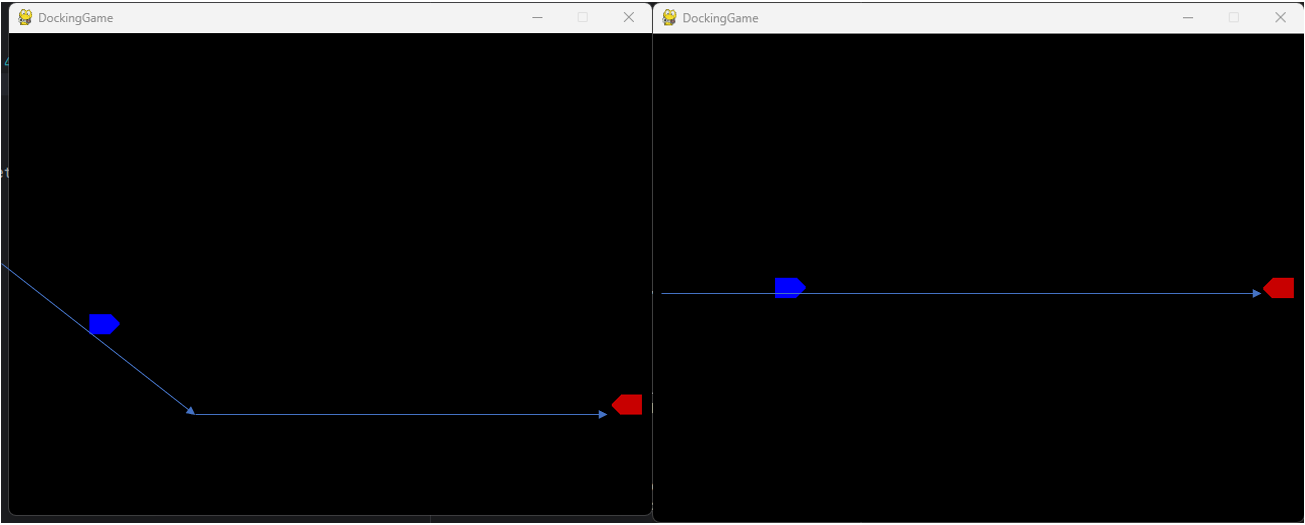

>In the above figure we can observe that as the target ship gets closer to the middle of the vertical axis, the previous Eulerian distance between the tracking ship and the target ship gets closer. We know that the longer an agent is operating in its environment, the more actions it needs to attempt. Therefore the more epochs required for training.


###Model 3 part 6:Model Training
>To address the problems posed by the above phenomenon, we individually parameterize the Greedy strategy for the different situations generated by the target in different Y coordinates. More specifically, as the previous distance between the target and the chaser gets smaller, the agent will start to rely more on experience to choose its actions earlier.

>This function  is used to train the best model of the Agent under different environmental parameters. These environmental parameters include the target's Y-coordinate and thresholds.

- Initialize a new Agent object.

- For each training cycle, the reset method is called first to initialize the environment.

- During the training process, the Agent chooses an action based on the current state, gets a new state, a reward. This information is used for immediate training (train_short_memory) and stored in the memory bank. All rewards are accumulated and used to evaluate overall performance for this game cycle.

- Once the game is over it is checked if the number of games has reached the threshold . If it is reached the training is ended. Otherwise, the train_long_memory method is called to train using experience from the memory bank.

- The best_model_train() function iterates over all Y coordinate and threshold combinations, training once for each set of parameters. The purpose of this is to find, for each Y coordinate, the threshold that best fits its performance.









In [ ]:
def best_model_train():
    Y_coord_arr = [40, 80, 120, 160, 200, 240, 280, 320, 360, 400, 440]
    thresholds = [400, 380, 360, 340, 320, 300, 320, 340, 360, 380, 400]

    def train(Y, threshold):
        plot_game_epoch = []
        plot_reward_total = []
        agent = Agent()
        plot_preference = []
        env = DockingGame(Y_pos=Y)
        for i in range(10000000):
            env.reset()
            done = False
            reward_total = 0
            agent.n_games += 1
            while not done:
                plot_game_epoch.append(i)
                plot_reward_total.append(reward_total)
                plot_preference.append(agent.preference * 40 - 20)
                pygame.event.get()
                state_old = env.get_states()
                action = agent.get_action(state_old, threshold)
                env.ai_player_step(action)
                reward = env.compute_reward()
                done = env.is_game_over
                state_new = env.get_states()
                agent.train_short_memory(state_old, action, reward, state_new, done)
                agent.remember(state_old, action, reward, state_new, done)
                env.clock.tick(10000)
                reward_total += reward
            if agent.n_games == threshold + 10:
                plt.plot(plot_game_epoch, plot_reward_total, label='Total Reward')
                plt.plot(plot_game_epoch, plot_preference, label='preference on the actions of memory')
                plt.xlabel('Game epoch')
                plt.ylabel('Value')
                plt.legend()
                plt.title("Model performance for Y = " + str(Y))
                plt.show()

                break

            agent.train_long_memory()

    for Y in Y_coord_arr:
        for threshold in thresholds:
            train(Y, threshold)

###Model 3 part 7:Model Test


In [ ]:

MAX_MEMORY = 100_00000
BATCH_SIZE = 100
LR = 0.001

def load_model(model, filepath):
    model.load_state_dict(torch.load(filepath))
    model.eval()
    return model

def replay():
    agent = Agent()
    game = DockingGame()

    while True:
        pygame.event.get()
        state = game.get_states()
        state_tensor = torch.tensor(state, dtype=torch.float)
        model = load_model(agent.model, 'model/Y_' + str(game.target.y) + 'model.pth')
        prediction = model(state_tensor)
        move = torch.argmax(prediction).item()
        final_move = [0, 0, 0]
        final_move[move] = 1
        action = final_move
        game.ai_player_step(action)
        if game.is_game_over:
            game.reset()
        game.clock.tick(300)


replay()


###Model 3 part 8:Model 3 Results


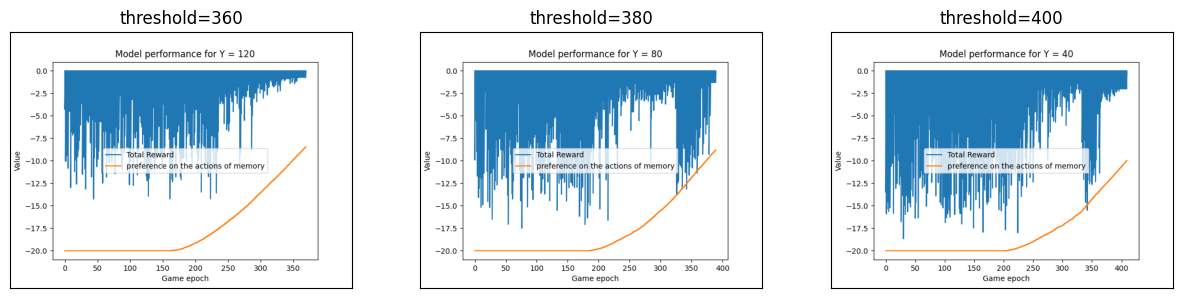

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('threshold=360.png')
img2 = mpimg.imread('threshold=380.png')
img3 = mpimg.imread('threshold=400.png')

fig, axs = plt.subplots(1, 3, figsize=(15,5))  # 1 row, 3 images

axs[0].imshow(img)
axs[0].set_title('threshold=360')
axs[1].imshow(img2)
axs[1].set_title('threshold=380')
axs[2].imshow(img3)
axs[2].set_title('threshold=400')

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()


>The above three graphs reflect the convergence performance of the model in the three Y coordinates. Where the blue curve represents the development curve of the total reward received by the intelligences in each round. The orangecurve represents the intelligence's dependence on experience. This is a weighted visualization of the data. We can find that at Y=360, the intelligences start choosing to gradually rely on experience after about 170 epochs. And after 350 epochs, the total experience gained by the intelligent body per epoch stabilizes. This means that the intelligent body has found the best strategy. After this the intelligent body will rely 100% on experience for its actions to prevent the occurrence of overfitting.
<br>And at Y=40, the Eulerian distance between chaser and target is relatively larger in this case. So the model converges relatively more slowly. It converges completely after about 400 epochs.

#Discussion

>This project aims to use different models of the agent to test the performance in the simple game environment. The team customized the game environment by using pygame and attempted to achieve goals based on three models. The three models are in an advanced relationship. In model 1, basic network structure is used to process the state of the game environment, the results were minimal. Therefore, in model 2, on the basis of model 1, DQN was added. Powered by the application of deep reinforcement learning, the performance of the agent is significantly improved. Furthermore, In model 3, The team adjusted the parameters and fused the model separately according to different y values. Successfully achieved better stability and learning results than conventional methods.
<br>Although Model 3 achieved good results, it also exposed some flaws. First, In complex environments or for tasks with large-scale action spaces, the training process of DQN may be unstable. This is evident on the Model 3, different y values correspond to different convergence functions. It is necessary to manually adjust the parameters for each type of situation separately, otherwise there will be a case where the training cannot converge.

>In addition, the model has many limitations. The team used neural networks instead of traditional Q-tables, which greatly reduced the required memory, but in order to improve the learning ability of the model, the experience replay technique is used. If the sample dimension increases, the size of the experience buffer will also increase, and the memory requirements for experience replay will be very high. On the other hand, the deep reinforcement learning method used in this project is based on value iteration, which makes it suitable for discrete action value selection and does not work well for continuous action values.
<br>For future applications, there may be larger action sets in more complex game environments. The team needs to try more complex algorithms to enhance the nonlinear fitting ability of the model and the model parameters can be trained using multiple GPUs, which can effectively improve the convergence speed of the algorithm. In addition, the team may explore more about the application of deep reinforcement learning in continuous action selection, such as the automatic driving of cars.
